In [1]:
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

In [2]:
import qcodes as qc
from qcodes import load_by_id
from qcodes.dataset.measurements import Measurement
from qcodes.instrument.base import Instrument
from qcodes.instrument.parameter import Parameter

In [3]:
from pytopo.qctools.instruments import create_inst
from pytopo.qctools.dataset2 import select_experiment

from plottr import client
from plottr.qcodes_dataset import QcodesDatasetSubscriber

from pytopo.mplplots.init_nb_plotting import *

qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

In [103]:
from qcodes.instrument_drivers.QuTech.IVVI import IVVI
ivvi = create_inst(IVVI, "ivvi", "ASRL5::INSTR")

from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
key1 = create_inst(Keysight_34465A, "key1", "TCPIP::169.254.4.62::INSTR", force_new_instance=True)
key2 = create_inst(Keysight_34465A, "key2", "TCPIP::169.254.4.61::INSTR", force_new_instance=True)

for i in range(1,16):
    ivvi.parameters['dac{}'.format(i)].set_step(0.5)
    ivvi.parameters['dac{}'.format(i)].set_delay(0.001)
    
ivvi.dac1.set_delay(0.001)
ivvi.dac1.set_step(20)

ivvi.dac2.set_delay(0.001)
ivvi.dac2.set_step(20)

ivvi.dac3.set_delay(0.001)
ivvi.dac3.set_step(2)

Instrument ivvi already exists.
Instrument key1 already exists.
Connected to: Keysight Technologies 34465A (serial:MY57503135, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.21s
Instrument key2 already exists.
Connected to: Keysight Technologies 34465A (serial:MY57503556, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.16s


d:\onedrive\bf1\code\qcodes\qcodes\instrument\parameter.py:518: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
d:\onedrive\bf1\code\qcodes\qcodes\instrument\parameter.py:530: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "


In [28]:
key1.NPLC(1)
key2.NPLC(1)

In [124]:
ivvi.set_dacs_zero()


In [107]:
ivvi.dac3(-50)

In [6]:
class ConversionParameter(Parameter):
    
    def __init__(self, name, src_param, get_conv, set_conv=None, **kw):
        super().__init__(name, **kw)
        self.src_param = src_param
        self.get_conv = get_conv
        self.set_conv = set_conv
    
    def get_raw(self):
        return self.get_conv(self.src_param())
    
    def set_raw(self, value):
        if self.set_conv is None:
            raise NotImplementedError("No set conversion implemented.")
        
        return self.src_param(self.set_conv(value))
    

class IVVISetup(Instrument):
    
    def __init__(self, name, ivvi, **kw):
        super().__init__(name, **kw)
        
        self.ivvi = ivvi
        
        self.add_parameter('voltage_multiplier', get_cmd=None, set_cmd=None, 
                           initial_value=1e-3)
        self.add_parameter('iso_in_multiplier', get_cmd=None, set_cmd=None,
                           initial_value=1e-2)

        for i in range(1, self.ivvi._numdacs + 1):       
            self.add_parameter('dac{}'.format(i), unit='V',
                               get_cmd=self.ivvi._gen_ch_get_func(self._get_dac, i),
                               set_cmd=self.ivvi._gen_ch_set_func(self._set_dac, i))
            
    def _get_dac(self, ch):
        return self.ivvi.get('dac{}'.format(ch)) * 1e-3 * self.voltage_multiplier()
    
    def _set_dac(self, ch, val):
        return self.ivvi.set('dac{}'.format(ch), val * 1e3 / self.voltage_multiplier())

In [110]:
ivvi_setup = create_inst(IVVISetup, 'ivvi_setup', ivvi=ivvi, force_new_instance=True)
ivvi_setup.voltage_multiplier(100e-9)

ivvi_setup.add_parameter('gate_current', parameter_class=ConversionParameter, unit='V',
                         src_param=key2.volt, get_conv=lambda x: x/1e6)
ivvi_setup.add_parameter('v_measurement', parameter_class=ConversionParameter, unit='V',
                         src_param=key1.volt, get_conv=lambda x: x/200)

Instrument ivvi_setup already exists.


In [123]:
exp = select_experiment('BF1 394114 wirebatch test', 'DEV_17')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac2)
meas.register_parameter(ivvi_setup.gate_current, setpoints=[ivvi_setup.dac2, ])
meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac2, ])


srcvals = np.linspace(-100e-9, 100e-9, 401)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s in srcvals:
        ivvi_setup.dac2(s)
        datasaver.add_result((ivvi_setup.dac2, s), 
                             (ivvi_setup.gate_current, ivvi_setup.gate_current()),
                             (ivvi_setup.v_measurement, ivvi_setup.v_measurement()))

Starting experimental run with id: 157


In [104]:
ivvi_setup = create_inst(IVVISetup, 'ivvi_setup', ivvi=ivvi, force_new_instance=True)
ivvi_setup.voltage_multiplier(15)

ivvi_setup.add_parameter('gate_current', parameter_class=ConversionParameter, unit='V',
                         src_param=key2.volt, get_conv=lambda x: x/1e6)
ivvi_setup.add_parameter('i_measurement', parameter_class=ConversionParameter, unit='V',
                         src_param=key1.volt, get_conv=lambda x: x/1e6)

Instrument ivvi_setup already exists.


In [105]:
exp = select_experiment('BF1 394114 wirebatch test', 'DEV_2')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac3)
meas.register_parameter(ivvi_setup.gate_current, setpoints=[ivvi_setup.dac3, ])
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ivvi_setup.dac3, ])

ivvi.dac1(1000)
srcvals = np.linspace(0, -10, 201)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s in srcvals:
        ivvi_setup.dac3(s)
        datasaver.add_result((ivvi_setup.dac3, s), 
                             (ivvi_setup.gate_current, ivvi_setup.gate_current()),
                             (ivvi_setup.i_measurement, ivvi_setup.i_measurement()))

Starting experimental run with id: 149


KeyboardInterrupt: 

In [95]:
ivvi.dac1()

999.98474097810322

<IPython.core.display.Javascript object>


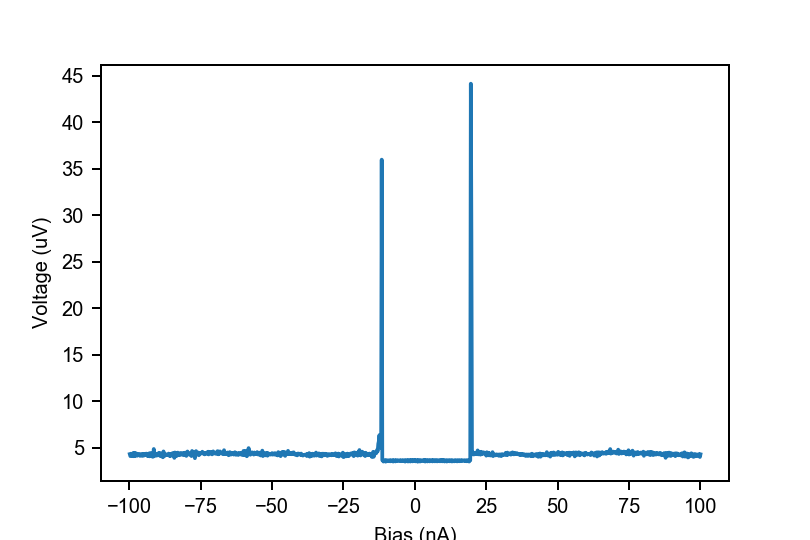

In [26]:
bvals = np.array(datasaver.dataset.get_data('ivvi_setup_dac1')).reshape(-1) * 1e9
vvals = np.array(datasaver.dataset.get_data('ivvi_setup_v_measurement')).reshape(-1) * 1e6
# ivals = np.array(datasaver.dataset.get_data('ivvi_setup_i_measurement')).reshape(-1) * 1e9

fig, ax = plt.subplots(1, 1, )
ax.plot(bvals[1:], np.diff(vvals), '-')
ax.set_xlabel('Bias (nA)')
ax.set_ylabel('Voltage (uV)')

In [19]:
(vvals.max() - vvals.min())/(bvals.max()-bvals.min())

21.607304899999999